# Phase transition

In [1]:
from qiskit.quantum_info import Statevector, SparsePauliOp, Operator, partial_trace, entropy, DensityMatrix

import itertools as it
import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

from utils import *
from dqpt import *
from spin_ham import *

[('ZIZZZZ', 5.105088062083414), ('IIIZIZ', 5.105088062083414), ('IIZIIZ', 5.105088062083414), ('ZIZZZZ', 5.105088062083414), ('ZIIIZI', 5.105088062083414), ('IIZZZZ', 5.105088062083414)]


Text(-0.09, -0.25, '(b)')

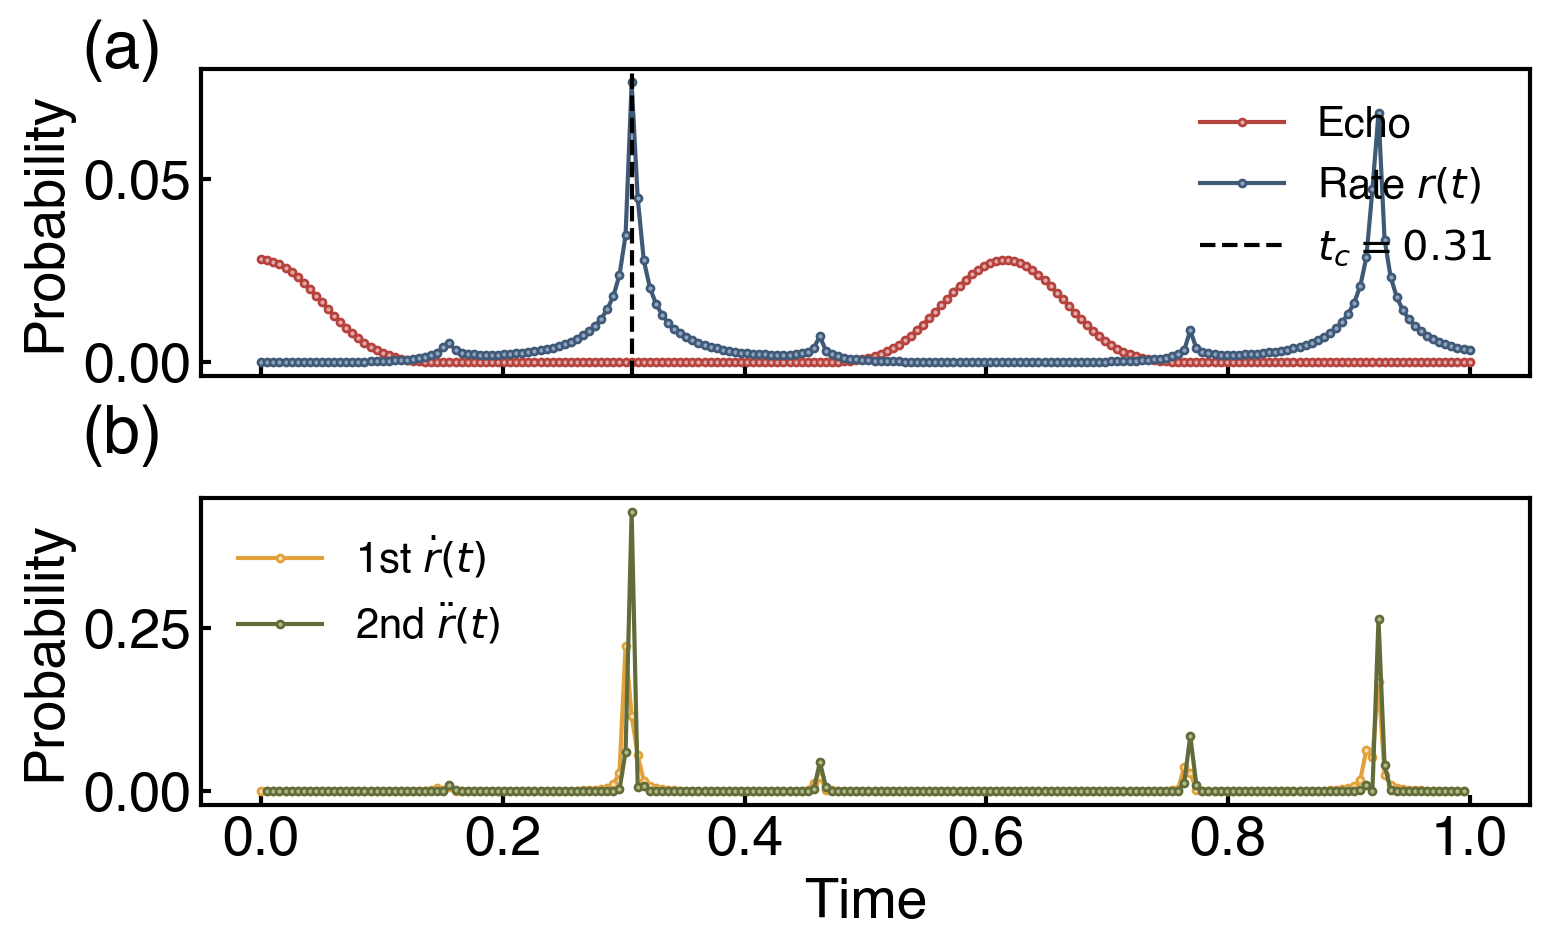

In [2]:
n = 6
r_pf = 50
t_max, t_n = 1.0, 200
t_list = np.linspace(0, t_max, t_n)

def IQP_H(n, theta=0, verbose=False):
    if theta == 0:
        pstr = [(''.join(random.choices(['I','Z'], k=n)), 2*np.pi*random.random()) for _ in range(1*n)]
    else:
        pstr = [(''.join(random.choices(['I','Z'], k=n)), theta) for _ in range(1*n)]
    # pstr = [(''.join(random.choices(['I','Z'], k=n)), 2*random.random()-1) for _ in range(1*n)]
    # pstr = [(random.choices(['I','Z'], k=n), list(range(0,n)), 2*random.random()-1) for _ in range(n)]
    if verbose: print(pstr)
    return SparsePauliOp.from_list(pstr)
    # return SparsePauliOp.from_sparse_list(pstr, n)

# H_type, theta = 1, 0
H_type, theta = 1, np.pi/8 * 13
if H_type == 0:
    J = 2
    ising_str = 'ZZ' + 'I' * (n-2)
    uni_ising = [(ising_str[i:]+ising_str[:i], J) for i in range(n)]
    del uni_ising[1]
    print(uni_ising)
    H =  SparsePauliOp.from_list(uni_ising)
else:
    # H = get_hamiltonian(L=n, J=1.0, h=0.2, g=0.0, verbose=True)
    H = IQP_H(n, theta, verbose=True)

init_state = Statevector.from_label('+'*n)
echo_list = []
for t in t_list:
    final_state = expm(-1j * t * H.to_matrix()) @ init_state.data
    echo = np.abs(init_state.data.conj() @ final_state)**2
    # print('echo: ', echo)
    echo_list.append(echo)
rate_list = [-np.log(echo)/n for echo in echo_list]

fig, axes = plt.subplots(2, 1, figsize=(8, 5), layout='tight', sharex=True, dpi=100)

plot_evo(axes[0], t_list, echo_list/sum(echo_list), '.-', ylabel='Percent', label='Echo')
plot_evo(axes[0], t_list, normalize(rate_list), '.-', ylabel='Probability', label=rf'Rate $r(t)$')
t_c = t_list[np.argmin(echo_list)]
axes[0].axvline(t_c, ls='--', color='k', label=f'$t_c = {t_c:.2f}$')

derivative_1st = ob_dt(rate_list, t_list)
derivative_2nd = ob_dt(rate_list, t_list, ord=2)
plot_evo(axes[1], t_list[:-1], normalize(derivative_1st), '.-', ylabel='Amplitude', label=r'1st $\dot{r}(t)$', color=color_cycle[3])
plot_evo(axes[1], t_list[1:-1], normalize(derivative_2nd), '.-', ylabel='Probability', label=r'2nd $\ddot{r}(t)$', color=color_cycle[2])

axes[0].legend(); axes[1].legend(); axes[1].set_xlabel('Time')
axes[0].text(-.09, 1.0, f'(a)', transform=axes[0].transAxes, size=24, weight='bold')
axes[1].text(-.09, -0.25, f'(b)', transform=axes[0].transAxes, size=24, weight='bold')
# fig.savefig(f'../figs/IQP_dqpt_echo_rate_n={n}_t={t_max}_tn={t_n}.pdf', bbox_inches='tight', transparent=True)